<a href="https://colab.research.google.com/github/sawczukanalytics/analytics-portfolio/blob/main/scripts/K_Means_clustering_of_passes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplsoccer==1.2.4 --quiet
!pip install tqdm==4.66.4 --quiet
!pip install scikit-learn-extra==0.2.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.5/813.5 kB 11.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplsoccer as mpl
import sklearn.cluster as cluster
import sklearn.metrics as metrics

from sklearn_extra.cluster import KMedoids
from tqdm import tqdm

In [3]:
seed = 27

# Introduction
---

The aim of this script is to try to gain more insight into player passing performances using some clustering techniques. As with most of these notebooks, the underlying work should be credited to [Soccermatics](https://soccermatics.readthedocs.io/en/latest/gettingstarted.html), [Devin Pleuler](https://github.com/devinpleuler/analytics-handbook?tab=readme-ov-file) and [socceraction](https://socceraction.readthedocs.io/en/latest/documentation/intro.html), but I have regularly combined their suggestions or taken things beyond their initial examples to develop my own understanding of how to do things. For the purposes of this script, I'll use the StatsBomb data from 2015/16 as it provides one of the more complete sets of free data across five top European leagues.

# Importing data
---

We will use the Sbopen() parser to import data again. Rather than solely considering El Classico matches, let's now consider the whole 2015/16 La Liga season. We know from last time that we want competition_id = 11, season_id = 27.

In [4]:
# Assign the parser (note slight change in code as I've just imported the whole mpl soccer package here)
sb_parser = mpl.Sbopen()

# Get La Liga matches and convert to dictionary for processing
# orient="records" keeps all rows of the dataframe together within the dictionary
laliga_matches = sb_parser.match(competition_id=11, season_id=27)
laliga_dict = laliga_matches.to_dict(orient = "records")

We process the data to only include passes for now. We create a list with the start and end coordinates for each pass, then we pass the list as a dataframe so we can analyse all the pass data. Unfortunately, as this notebook expanded, it kept crashing when I attempted to use all 380 matches, so the below examples only use the first 25 matches of the season now. I'll run some analyses with all 380 matches locally and upload them at some point.

In [7]:
# Create list for all events
all_events = []

# Loop through the first 25 elements of the dictionary of matches
for m in tqdm(laliga_dict[0:25]):
  # Get event data
  events = sb_parser.event(match_id = m["match_id"])[0]
  # Filter down to passes
  passes = events.loc[events["type_name"] == "Pass"].copy()
  # Get the coordinates we want
  coords = np.vstack((passes["x"], passes["y"], passes["end_x"], passes["end_y"])).T
  # Add them to the list of all events
  all_events.extend(coords)

# Put coordinates into dataframe
passes_df = pd.DataFrame(all_events, columns=['x1', 'y1', 'x2', 'y2'])
passes_df.head(3)

100%|██████████| 25/25 [00:16<00:00,  1.47it/s]


,x1,y1,x2,y2
0,61.0,40.1,62.1,47.3
1,61.2,41.3,59.1,38.0
2,49.2,33.5,32.3,58.4


# K-Means Clustering
---

One of the simplest methods of clustering is K-Means clustering. K-Means clustering assigns all observations to the centroid (or mean) with the nearest set of co-ordinates. Distances from the centroid are calculated as the sum of the Euclidean distances squared. Means can be placed anywhere and the clusters usually have similar shapes.


In [8]:
# Using sklearn's k-means algorithm, the data can be fit in three lines.
# Initialise the model, describe the features, fit the model
kmeans_model = cluster.KMeans(n_clusters=50, random_state=seed)
kmeans_features = passes_df[['x1', 'y1', 'x2', 'y2']]
kmeans_fit = kmeans_model.fit(kmeans_features)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


After fitting the model, we can view the characteristics of the fit (e.g. look at the cluster characteristics via cluster_centres_ or labels_) or we can simply plot the results. We'll plot the results here so we can compare them to the K-Medoids Clustering shortly.

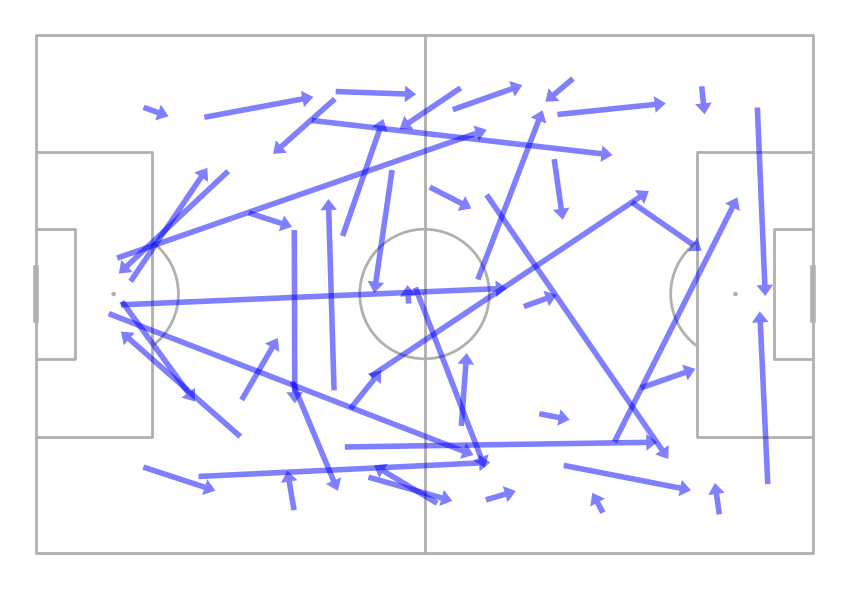

In [9]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=(9,6))
for coords in kmeans_fit.cluster_centers_:
  kmeans_p = pitch.arrows(*coords, alpha=0.5, color="blue", ax=ax,
                          headaxislength=2, headlength=2, headwidth=3, width=4)

# K-Medoids Clustering
---

K-Medoids clustering is similar to K-Means clustering, except it assigns all observations to the centroid (or median) with the nearest set of co-ordinates as measured by the Euclidean distance (not the squared Euclidean distance). K-Medoids clustering picks actual data points as centroids and is more robust to outliers because of its measurement technique (using pairwise similarity measures rather than the sum of squared Euclidean distances). It can also use arbitrary dissimilarity measures depending on the needs of the analysis, but we won't consider this here.

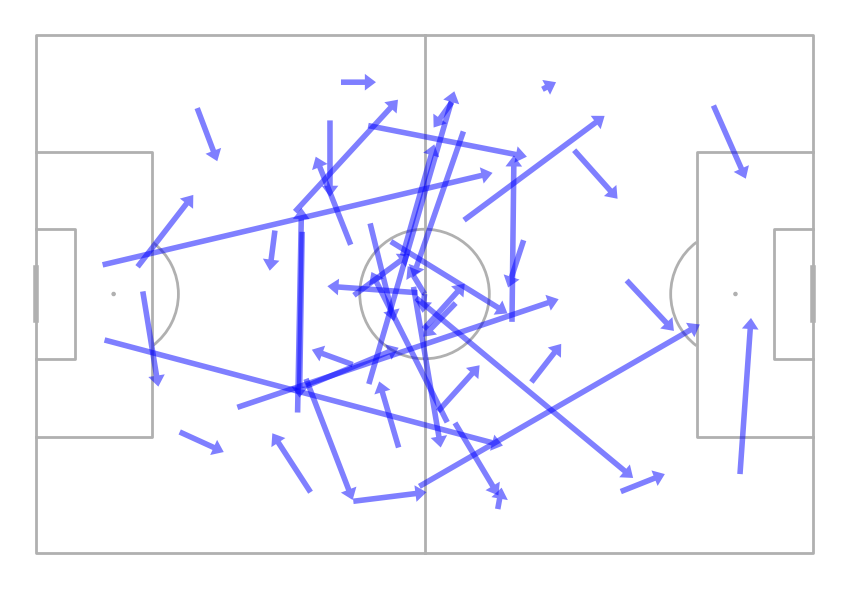

In [10]:
# Sklearn extra's k-medoids algorithm has the same syntax as the k-means model
# Initialise the model, describe the features, fit the model
kmeds_model = KMedoids(n_clusters=50, random_state=seed)
kmeds_features = passes_df[['x1', 'y1', 'x2', 'y2']]
kmeds_fit = kmeds_model.fit(kmeds_features)

pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=(9,6))
for coords in kmeds_fit.cluster_centers_:
  kmeds_p = pitch.arrows(*coords, alpha=0.5, color="blue", ax=ax,
                         headaxislength=2, headlength=2, headwidth=3, width=4)

# K-Means vs K-Medoids in Football

Although K-Means clustering is a simpler technique that K-Medoids clustering, it appears to give a better all round representation of the passes that take place. K-Means is able to place clusters anywhere on the pitch, whereas K-Medoids uses actual data points for clusters which is supposed to improve interpretability and robustness to outliers. However, within a footballing context, it appears to result in the majority of centroids being put in the middle of the pitch, whereas the K-Means clustering approach provides a more complete view of the pitch with more centroids on the wings and closer to each penalty area.

One of the problems with K-Means clustering is that it requires the user to select the number of clusters in the model, which could have a significant impact on the results. The code below runs further models at 20, 30, 40, 60 and 70 centroids to show the differences in the clusters identified by the model.

In [11]:
# Run more k-means models at 20, 30, 40, 60 and 70 centroids.
# The code can be much more condensed now as we already have a variable with the
# pass coordinates ("kmeans_features").
# Instead of initialising the model as a separate variable, this time we just
# create the fitted object
kmeans20_fit = cluster.KMeans(n_clusters=20, random_state=seed).fit(kmeans_features)
kmeans30_fit = cluster.KMeans(n_clusters=30, random_state=seed).fit(kmeans_features)
kmeans40_fit = cluster.KMeans(n_clusters=40, random_state=seed).fit(kmeans_features)
kmeans60_fit = cluster.KMeans(n_clusters=60, random_state=seed).fit(kmeans_features)
kmeans70_fit = cluster.KMeans(n_clusters=70, random_state=seed).fit(kmeans_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0.5, 1.0, '70 clusters')

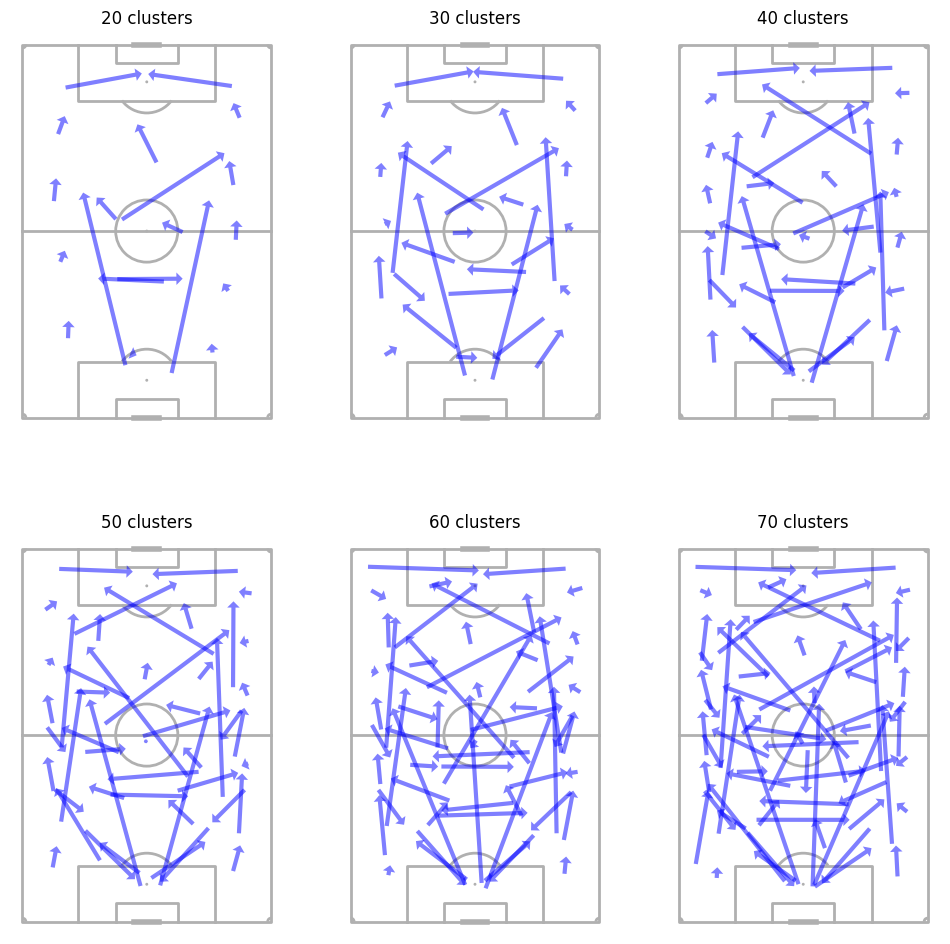

In [ ]:
# Create the figure with six subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 12))

# Create the pitches
# Notice how the axs argument has two parts now - a row index and a column index
pitch = mpl.VerticalPitch(corner_arcs=True)
pitch.draw(ax=axs[0, 0])
pitch.draw(ax=axs[0, 1])
pitch.draw(ax=axs[0, 2])
pitch.draw(ax=axs[1, 0])
pitch.draw(ax=axs[1, 1])
pitch.draw(ax=axs[1, 2])

# Loop through each fitted object plotting arrows in the appropriate plot
for coords in kmeans20_fit.cluster_centers_:
  kmeans20_p = pitch.arrows(*coords, alpha=0.5, color="blue", ax=axs[0, 0],
                            headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
for coords in kmeans30_fit.cluster_centers_:
  kmeans30_p = pitch.arrows(*coords, alpha=0.5, color="blue", ax=axs[0, 1],
                            headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
for coords in kmeans40_fit.cluster_centers_:
  kmeans40_p = pitch.arrows(*coords, alpha=0.5, color="blue", ax=axs[0, 2],
                            headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
for coords in kmeans_fit.cluster_centers_:
  kmeans50_p = pitch.arrows(*coords, alpha=0.5, color="blue", ax=axs[1, 0],
                            headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
for coords in kmeans60_fit.cluster_centers_:
  kmeans60_p = pitch.arrows(*coords, alpha=0.5, color="blue", ax=axs[1, 1],
                            headaxislength=1.5, headlength=1.5, headwidth=3, width=3)
for coords in kmeans70_fit.cluster_centers_:
  kmeans70_p = pitch.arrows(*coords, alpha=0.5, color="blue", ax=axs[1, 2],
                            headaxislength=1.5, headlength=1.5, headwidth=3, width=3)

# Add plot titles
axs[0, 0].set_title("20 clusters")
axs[0, 1].set_title("30 clusters")
axs[0, 2].set_title("40 clusters")
axs[1, 0].set_title("50 clusters")
axs[1, 1].set_title("60 clusters")
axs[1, 2].set_title("70 clusters")


When looking at the plots above, we can see that some of the fundamental passing features are maintained (e.g., crosses, passing between centre backs (presumably) and goalkeeper clearances (again presumably)) as the number of centroids is reduced. However, some features are lost (e.g., forward diagonal passes become less frequent, as do horizontal "possession keeping" passes and vertical progressive passes) so it's reasonable to question what the optimal number of centroids is.

One method through which the optimal number of clusters can be considered is the "Elbow Method". The Elbow Method involves visualising the accuracy of the clustering over a range of centroid inputs (in the example above, the results would be plotted for 20, 30, 40, 50, 60 and 70 clusters). In situations where the ground truth label is not known, we can use the following accuracy metrics:

*   **Silhouette Coefficient**: A measure of how similar an observation is to its own cluster (cohesion) compared to other clusters (separation).
*   **Calinski-Harabasz Index** (sometimes called the variance ratio criterion): The ratio between the between cluster variance and the within cluster variance.
*   **Davies-Bouldin Index** (essentially the reverse of the Calinski-Harabasz index): The ratio between the within cluster variance and the between cluster variance.
*   **Inertia**: A measure of the within cluster variance (sum of squared distances). Probably the worst of the four measures discussed here as it is not a normalised metric

For the Silhouette Coefficient and the Calinksi-Harabasz Index, higher scores are better. A lower score is better for the Davies-Bouldin Index and Inertia.

Below, we plot the results of each metric showing and apply the Elbow Method to determine an appropriate number of clusters.



In [ ]:
# Initialise lists
clusters = list(range(5, 105, 5))
inertias = []
silhouettes = []
calinski_harabasz = []
davies_bouldin = []

# Run k-means for all cluster sizes from 5 to 105 clusters.
for i in clusters:
  # Run the kmeans algorithm
  kmeans = cluster.KMeans(n_clusters=i, random_state=seed).fit(kmeans_features)

  # Add all the metrics to the
  inertias.append(kmeans.inertia_)
  silhouettes.append(metrics.silhouette_score(kmeans_features, kmeans.labels_, metric='euclidean'))
  calinski_harabasz.append(metrics.calinski_harabasz_score(kmeans_features, kmeans.labels_))
  davies_bouldin.append(metrics.davies_bouldin_score(kmeans_features, kmeans.labels_))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0.5, 0, 'Number Centroids')

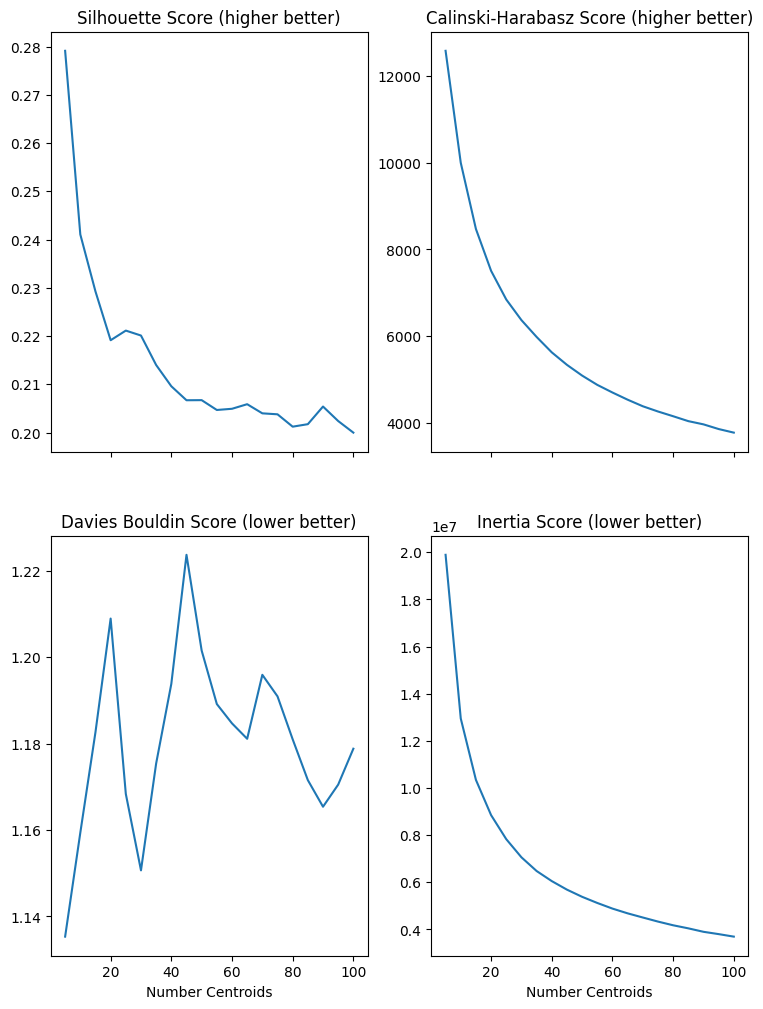

In [ ]:
# Create the figure with four subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 12), sharex=True)

# Silhouette scores
axs[0,0].plot(clusters, silhouettes)
axs[0,0].set_title("Silhouette Score (higher better)")
# Calinski-Harabasz scores
axs[0,1].plot(clusters, calinski_harabasz)
axs[0,1].set_title("Calinski-Harabasz Score (higher better)")
# Davies Bouldin scores
axs[1,0].plot(clusters, davies_bouldin)
axs[1,0].set_title("Davies Bouldin Score (lower better)")
# Inertia scores
axs[1,1].plot(clusters, inertias)
axs[1,1].set_title("Inertia Score (lower better)")

# Label the shared x-axes
axs[1,0].set_xlabel("Number Centroids")
axs[1,1].set_xlabel("Number Centroids")

The plots above show the accuracy metrics for 20 K-Means models (centroids from 5 to 105 in increments of 5). The Calinski-Harabasz and Inertia scores are particularly smooth, meaning we can't get much information out of them. Based on the Silhouette scores, we appear to have two elbows: one at approximately 25-30 centres and one at approximately 40-45.

Given the concurrent drop in the Davies Bouldin score at around 25-30 centroids and increase at 40-45 centres, it makes sense to accept the 30 centre model (remember lower scores are better in the Davies Bouldin metric) but I'd still argue that this misses some information - particularly in the defensive half of the pitch.

# Using K-Means clustering in practice

After establishing that 30 centroids is the best model for the current set of input data (not necessarily an accurate assumption given we only used 25 matches to start with), let's see how it works in practice by assigning all the passes made by Barcelona across a season to each of the 30 clusters on a match by match basis. Instead of plotting, this time I'll create a table which shows the median and IQR of the number of passes in each cluster by home/away status to assess it's variability between venues and matches over the season. It feels like we should see more consistency at home given the pitch size remains constant.

In [33]:
# Get all 19 home matches for Barcelona
barca_home = laliga_matches.loc[(laliga_matches["home_team_name"] == "Barcelona")].to_dict(orient = "records")

# Set up lists for the loop
home_dict = dict()
home_dict["centroid"] = list(range(0,30))

# Loop through the 19 home matches
for m in tqdm(barca_home):

  # Set up passes list
  home_passes = []
  # Get event data
  events = sb_parser.event(match_id = m["match_id"])[0]
  # Filter down to passes
  passes = events.loc[events["type_name"] == "Pass"].copy()
  # Get the coordinates we want
  coords = np.vstack((passes["x"], passes["y"], passes["end_x"], passes["end_y"])).T
  # Add them to the list of all events
  home_passes.extend(coords)
  # Put coordinates into dataframe
  barca_home_passes = pd.DataFrame(home_passes, columns=['x1', 'y1', 'x2', 'y2'])

  # Predict clusters from the passes
  home_pass_clusters = kmeans30_fit.predict(barca_home_passes[['x1', 'y1', 'x2', 'y2']])

  # Add counts and proportions to the dictionary
  _, home_dict["{}_count".format(m["match_id"])] = np.unique(home_pass_clusters, return_counts=True)
  home_dict["{}_prop".format(m["match_id"])] = home_dict["{}_count".format(m["match_id"])] / sum(home_dict["{}_count".format(m["match_id"])])

# Create a count dataframe and a proportion dataframe
home_pass_counts = pd.DataFrame.from_dict(
    {k: v for k, v in home_dict.items() if 'centroid' in k or 'count' in k}
)
home_pass_props = pd.DataFrame.from_dict(
    {k: v for k, v in home_dict.items() if 'centroid' in k or 'prop' in k}
)

# Now get median and interquartile range in a separate dataframe
home_summary = pd.DataFrame()
home_summary["centroid"] = home_pass_counts["centroid"]
# Counts
home_summary["count_median"] = home_pass_counts.iloc[:, 1:].median(axis=1)
home_summary["count_lq"] = home_pass_counts.iloc[:, 1:].quantile(0.25, axis=1)
home_summary["count_uq"] = home_pass_counts.iloc[:, 1:].quantile(0.75, axis=1)
home_summary["count_iqr"] = home_summary["count_uq"] - home_summary["count_lq"]
# Proportions
home_summary["prop_median"] = home_pass_props.iloc[:, 1:].median(axis=1)
home_summary["prop_lq"] = home_pass_props.iloc[:, 1:].quantile(0.25, axis=1)
home_summary["prop_uq"] = home_pass_props.iloc[:, 1:].quantile(0.75, axis=1)
home_summary["prop_iqr"] = home_summary["prop_uq"] - home_summary["prop_lq"]

home_summary

100%|██████████| 19/19 [00:12<00:00,  1.50it/s]


,centroid,count_median,count_lq,count_uq,count_iqr,prop_median,prop_lq,prop_uq,prop_iqr
0,0,50.0,38.0,60.0,22.0,0.048356,0.036744,0.059201,0.022457
1,1,31.0,26.5,37.0,10.5,0.029952,0.027137,0.037052,0.009915
2,2,22.0,16.0,27.0,11.0,0.020972,0.016234,0.027678,0.011443
3,3,33.0,25.5,36.5,11.0,0.031083,0.024719,0.036393,0.011674
4,4,20.0,14.5,23.0,8.5,0.019830,0.014131,0.022686,0.008555
5,5,27.0,23.5,29.0,5.5,0.026119,0.022333,0.028910,0.006577
6,6,13.0,8.5,15.5,7.0,0.014223,0.008175,0.015268,0.007093
7,7,42.0,37.0,51.5,14.5,0.041546,0.036441,0.053063,0.016621
8,8,67.0,57.0,77.5,20.5,0.063419,0.058732,0.077504,0.018772
9,9,20.0,18.0,23.5,5.5,0.019874,0.017384,0.023265,0.005881


In [34]:
# Get all 19 away matches for Barcelona
barca_away = laliga_matches.loc[(laliga_matches["away_team_name"] == "Barcelona")].to_dict(orient = "records")

# Set up lists for the loop
away_dict = dict()
away_dict["centroid"] = list(range(0,30))

# Loop through the 19 home matches
for m in tqdm(barca_away):

  # Set up passes list
  away_passes = []
  # Get event data
  events = sb_parser.event(match_id = m["match_id"])[0]
  # Filter down to passes
  passes = events.loc[events["type_name"] == "Pass"].copy()
  # Get the coordinates we want
  coords = np.vstack((passes["x"], passes["y"], passes["end_x"], passes["end_y"])).T
  # Add them to the list of all events
  away_passes.extend(coords)
  # Put coordinates into dataframe
  barca_away_passes = pd.DataFrame(away_passes, columns=['x1', 'y1', 'x2', 'y2'])

  # Predict clusters from the passes
  away_pass_clusters = kmeans30_fit.predict(barca_away_passes[['x1', 'y1', 'x2', 'y2']])

  # Add counts and proportions to the dataframe
  _, away_dict["{}_count".format(m["match_id"])] = np.unique(away_pass_clusters, return_counts=True)
  away_dict["{}_prop".format(m["match_id"])] = away_dict["{}_count".format(m["match_id"])] / sum(away_dict["{}_count".format(m["match_id"])])

# Create a count dataframe and a proportion dataframe
away_pass_counts = pd.DataFrame.from_dict(
    {k: v for k, v in away_dict.items() if 'centroid' in k or 'count' in k}
)
away_pass_props = pd.DataFrame.from_dict(
    {k: v for k, v in away_dict.items() if 'centroid' in k or 'prop' in k}
)

# Now get median and interquartile range in a separate dataframe
away_summary = pd.DataFrame()
away_summary["centroid"] = away_pass_counts["centroid"]
away_summary["count_median"] = away_pass_counts.iloc[:, 1:].median(axis=1)
away_summary["count_lq"] = away_pass_counts.iloc[:, 1:].quantile(0.25, axis=1)
away_summary["count_uq"] = away_pass_counts.iloc[:, 1:].quantile(0.75, axis=1)
away_summary["count_iqr"] = away_summary["count_uq"] - away_summary["count_lq"]
away_summary["prop_median"] = away_pass_props.iloc[:, 1:].median(axis=1)
away_summary["prop_lq"] = away_pass_props.iloc[:, 1:].quantile(0.25, axis=1)
away_summary["prop_uq"] = away_pass_props.iloc[:, 1:].quantile(0.75, axis=1)
away_summary["prop_iqr"] = away_summary["prop_uq"] - away_summary["prop_lq"]

away_summary

100%|██████████| 19/19 [00:14<00:00,  1.27it/s]


,centroid,count_median,count_lq,count_uq,count_iqr,prop_median,prop_lq,prop_uq,prop_iqr
0,0,47.0,35.0,55.5,20.5,0.042972,0.036269,0.051193,0.014924
1,1,33.0,28.0,40.5,12.5,0.030735,0.029405,0.037934,0.008528
2,2,20.0,15.5,24.0,8.5,0.020211,0.014567,0.022771,0.008204
3,3,32.0,30.5,38.5,8.0,0.033130,0.028259,0.035968,0.007709
4,4,20.0,17.0,26.0,9.0,0.018467,0.016387,0.025370,0.008983
5,5,24.0,22.0,33.0,11.0,0.023631,0.020966,0.029157,0.008191
6,6,14.0,12.0,18.0,6.0,0.013538,0.011349,0.017459,0.006111
7,7,43.0,37.5,49.5,12.0,0.040422,0.034230,0.051946,0.017715
8,8,64.0,52.0,71.5,19.5,0.059688,0.053153,0.065342,0.012189
9,9,22.0,18.0,27.0,9.0,0.020630,0.017448,0.024990,0.007542


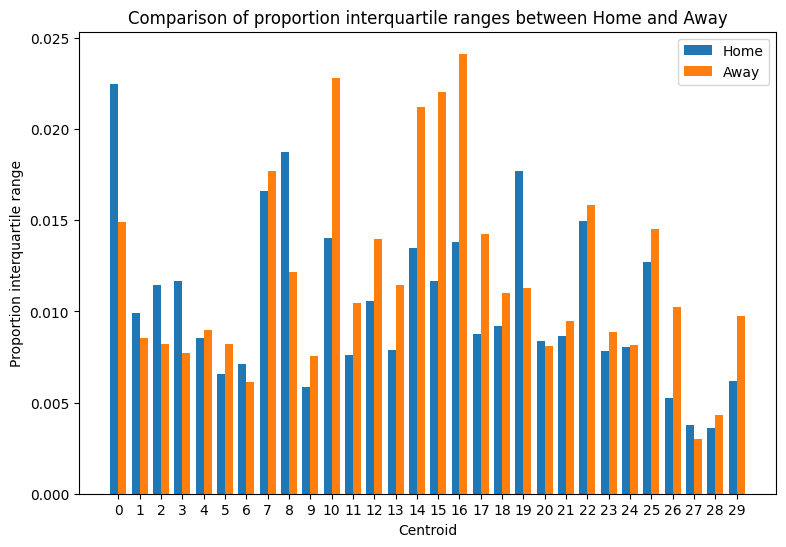

In [45]:
# Create a bar chart to show the differences in proportions
# Initialise the data
labels = home_summary['centroid']
home_values = home_summary['prop_iqr']
away_values = away_summary['prop_iqr']

# Initialise width of bars, and spacing between bars/clusters using the "*4"
x = range(0, len(labels) * 4, 4)
width = 1.5

# Create figure
fig, ax = plt.subplots(figsize=(9,6))
rects1 = ax.bar(x, home_values, width, label='Home')
rects2 = ax.bar([p + width for p in x], away_values, width, label='Away')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Centroid')
ax.set_ylabel('Proportion interquartile range')
ax.set_title('Comparison of proportion interquartile ranges between Home and Away')
ax.set_xticks([p + width/2 for p in x])
ax.set_xticklabels(labels)
ax.legend()

It's kind of hard to see what's going on from the tables above, so I added plot to compare the differences between home and away. I used the interquartile range of the proportions as I suspect there's inherently likely to be variability within the total counts of passes teams make. Even with the plot the differences don't look easy to make out. It's definitely not as clearcut as I thought that there's greater variability away than at home, but in the middle centroids (9-18), there appears to be a lot more in some cases. There's also an argument to look at the ratio of IQR to median proportion to find out the relative size of the variability but this will do for now. Let's find out where those differences are by plotting the k-means clusters again, but this time colour coding the arrows based on home or away having greater variability.

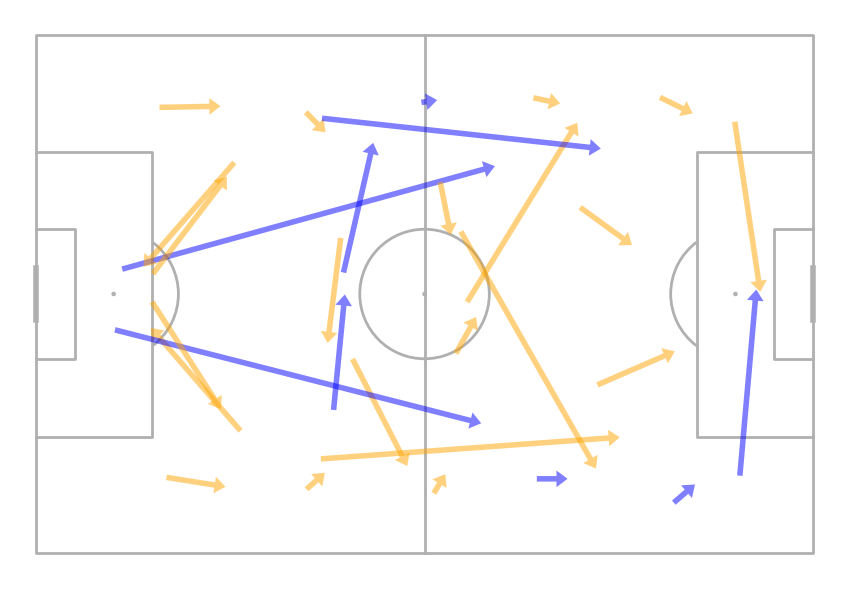

In [49]:
# Set up the pitch and plot
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=(9,6))

# Slight change to the
for i, coords in enumerate(kmeans30_fit.cluster_centers_):
    color = "blue" if home_summary["prop_iqr"].iloc[i] > away_summary["prop_iqr"].iloc[i] else "orange"
    pitch.arrows(*coords, alpha=0.5, color=color, ax=ax,
                 headaxislength=2, headlength=2, headwidth=3, width=4)

Interestingly, despite me deducing from the bar chart that there wasn't much difference between home and away venues, there actually appears to be a consistent trend that there is greater variability in away matches than home matches as initially hypothesized. Guess that shows the importance of visualising things appropriately. I'm still not wholly sure if this information is valuable or how or whether it would be better if the clustering was done on a team/positional basis though.